In [1]:
import warnings
warnings.filterwarnings('ignore')

# 1.Install required libraries:

In [2]:
!pip install gdown

In [3]:
import requests
import zipfile
import gdown

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Flatten, Dense, Dropout, Activation, LSTM, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Reshape, multiply
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import numpy as np
import cv2
import os

tf.random.set_seed(25)

2024-08-19 11:45:29.676101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 11:45:29.676230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 11:45:29.823533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered




---



# 2.1.Install dataset:

The dataset will be installed from the drive directly using `gdown` library. however, it will be installed as a zip file, `zipfile` library will be used to extract the data from the zip file.

In [4]:
url = 'https://drive.google.com/file/d/1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY/view?usp=drive_link'
output_path = '/kaggle/working/Teeth_Dataset.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=a271601b-66f1-46c7-ad4d-5967d820dd0b
To: /kaggle/working/Teeth_Dataset.zip
100%|██████████| 49.1M/49.1M [00:01<00:00, 40.0MB/s]


'/kaggle/working/Teeth_Dataset.zip'

In [5]:
extract_dir = '/kaggle/working/'

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

some additional files was found in testing dataset, so it was deleted.

In [6]:
!rm -rf "/kaggle/working/Teeth_Dataset/Testing/out"
!rm -rf "/kaggle/working/Teeth_Dataset/Testing/output"
!rm -rf "/kaggle/working/Teeth_Dataset/Testing/outputs"
!rm -rf "/kaggle/working/Teeth_Dataset/Testing/output_image.jpg"



---



# 2.2.Data processing:

a random image was read to know the dimension of the images.

In [7]:
im = cv2.imread('/kaggle/working/Teeth_Dataset/Training/CaS/a_100_0_1462.jpg')
print(im.shape)

(256, 256, 3)


In the next step, the data has been processed using `ImageDataGenerator`, The data was normalized using `rescale=1./255`, and then passed through augmentation process by shifting, rotation, zooming and sheering.
After Normalization and augmentation, the data was split into batches where each batch is 32 images.

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/Teeth_Dataset/Training',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/kaggle/working/Teeth_Dataset/Validation',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/Teeth_Dataset/Testing',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.




---



# 2.3.Data visualization

in the next steps, data will be visualized to to see the effectiveness of preprocessing techniques, and understand the balance between the distribution of classes, but first, let's see a full batch of the training dataset.

Image shape: (32, 256, 256, 3)
Label shape: (32, 7)


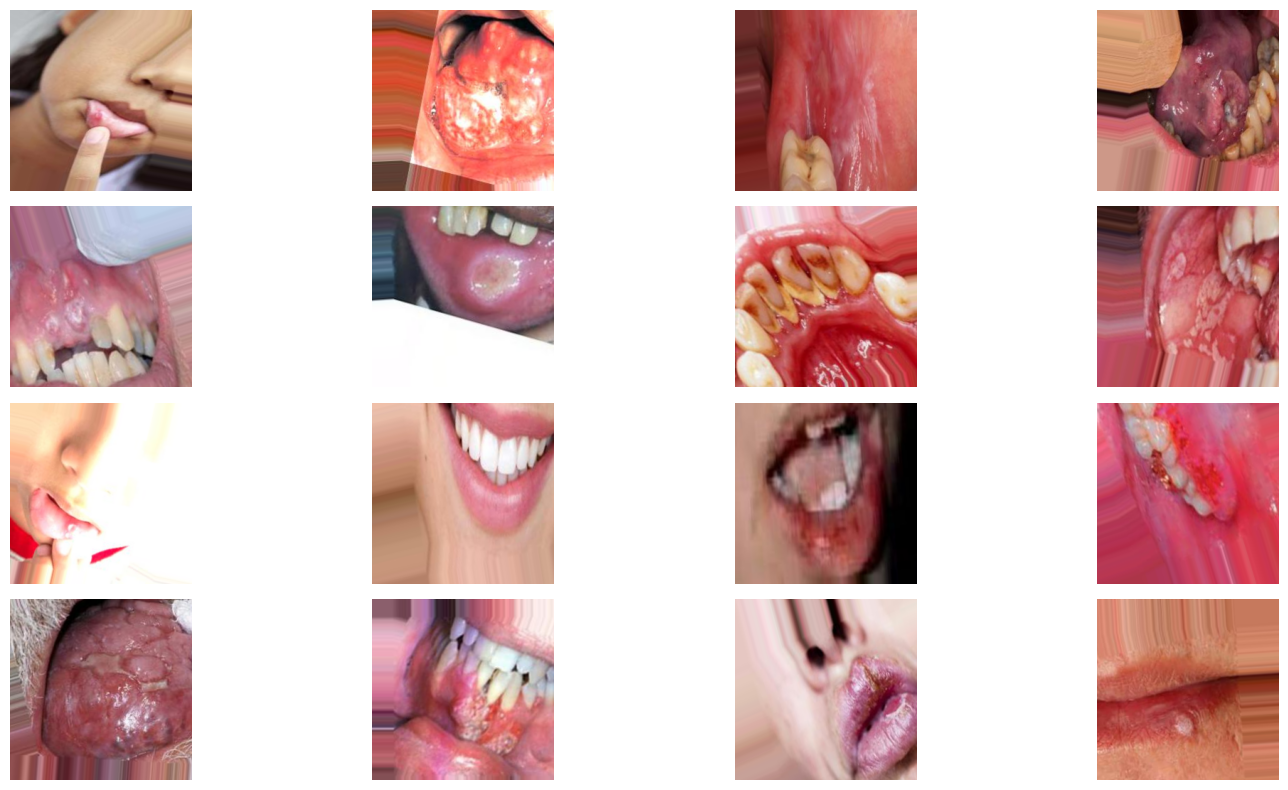

In [9]:
for x, y in train_generator:
    print("Image shape:", x.shape)
    print("Label shape:", y.shape)
    # Get the batch size
    batch_size = x.shape[0]

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 8))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for i in range(min(batch_size, 16)):
        # Convert image to RGB if necessary
        if x[i].shape[-1] == 1:
            image = np.squeeze(x[i], axis=-1)
        else:
            image = x[i]

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    break

Let's see the distribution of classes using a bar chart.

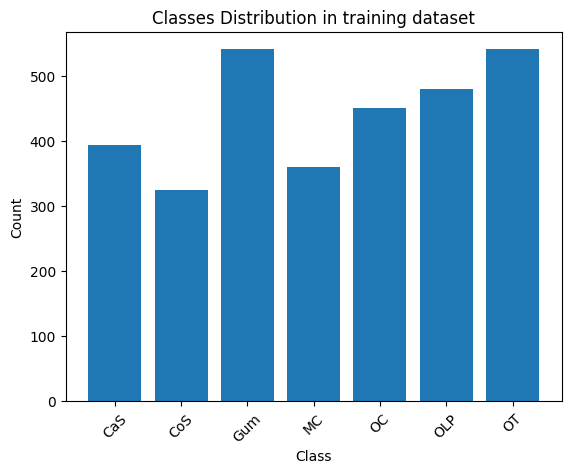

In [10]:
# Count the occurrences of each class
class_counts = []
for subfolder in os.listdir("/kaggle/working/Teeth_Dataset/Training"):
    subfolder_path = os.path.join("/kaggle/working/Teeth_Dataset/Training", subfolder)
    if os.path.isdir(subfolder_path):
      count = len(os.listdir(subfolder_path))
      class_counts.append(count)

# Get class names
class_names = list(train_generator.class_indices.keys())

# Create a bar chart
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Classes Distribution in training dataset')
plt.xticks(rotation=45)
plt.show()

Based on the graph above, we can conclude that the MC class will be the least accurate class, while CaS and OC will be the most accurate.
a class weighting technique was used during training to balance this issue.

we will see below a normal batch of data and an augmented one.

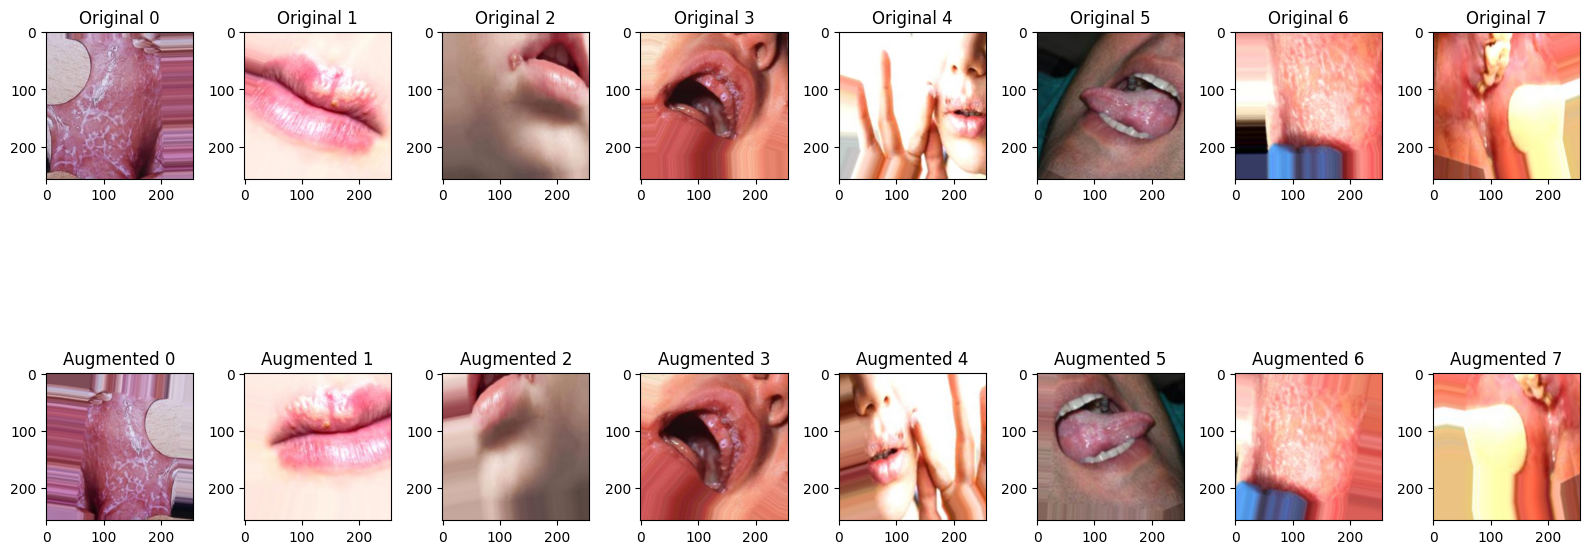

In [11]:
# Get a batch of images and labels
for x, y in train_generator:

    # Create a figure with two rows for displaying 8 images before and after
    fig, axes = plt.subplots(2, 8, figsize=(16, 8))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Iterate through the batch and display images
    for i in range(8):
        # Convert image to RGB if necessary (assuming grayscale handling)
        if x[i].shape[-1] == 1:
            original_img = np.squeeze(x[i], axis=-1)
        else:
            original_img = x[i]

        # Apply augmentations to the image
        augmented_img = train_datagen.random_transform(x[i])
        augmented_img = array_to_img(augmented_img)

        # Display original and augmented images
        axes[i].imshow(original_img)
        axes[i].set_title(f"Original {i}")
        axes[i + 8].imshow(augmented_img)
        axes[i + 8].set_title(f"Augmented {i}")

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()
    break



---



# 3.1.Model creation

Let's check the number of available GPUs to see if we can do parallelization

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


we will use parallelization using 2 A100 GPUs

In [13]:
strategy = tf.distribute.MirroredStrategy(['gpu:0', 'gpu:1'])

here we defined the model, a ResNet like architecture with attention blocks

In [14]:
with strategy.scope():
    def identity_block(x, filters):
        x_shortcut = x

        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, x_shortcut])
        x = Activation('relu')(x)
        return x

    def convolutional_block(x, filters, strides=1):
        x_shortcut = x

        x = Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)

        if strides != 1 or x_shortcut.shape[-1] != filters:
            x_shortcut = Conv2D(filters, (1, 1), strides=strides)(x_shortcut)
            x_shortcut = BatchNormalization()(x_shortcut)

        x = Add()([x, x_shortcut])
        x = Activation('relu')(x)
        return x

    def attention_block(x, filters):
        attention = Conv2D(filters // 8, (1, 1), activation='relu')(x)
        attention = Conv2D(filters, (1, 1))(attention)
        attention = Activation('sigmoid')(attention)
        x = multiply([x, attention])
        return x

    def create_model():
        inputs = Input(shape=(256, 256, 3))

        x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        x = convolutional_block(x, 64, strides=1)
        x = identity_block(x, 64)
        x = identity_block(x, 64)
        x = attention_block(x, 64)  

        x = convolutional_block(x, 128, strides=2)
        x = identity_block(x, 128)
        x = identity_block(x, 128)
        x = attention_block(x, 128)

        x = GlobalAveragePooling2D()(x)

        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(7, activation='softmax')(x)


        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.summary()
        model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        return model
    
    
    model = create_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 1,201,119 (4.58 MB)

 Trainable params: 1,198,431 (4.57 MB)

 Non-trainable params: 2,688 (10.50 KB)

# 3.2.Model training

we will make a class weight dictionary to address the imbalance issue in data.

In [15]:
class_weights = {}
for i in range(7):
    wieghted_class = max(class_counts)/class_counts[i]
    class_weights[i] = wieghted_class

let's see our class_weights dictionary

In [16]:
class_weights

{0: 1.3740458015267176,
 1: 1.6666666666666667,
 2: 1.0,
 3: 1.5,
 4: 1.2,
 5: 1.125,
 6: 1.0}

we will use a callback to save the model with highest validation accuracy after 100 epoch

In [17]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/checkpoint.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

we will run the model for 100 epoch and evaluate the results.

In [18]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    class_weight=class_weights,
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 88s 463ms/step - accuracy: 0.2412 - loss: 2.4136 - val_accuracy: 0.1537 - val_loss: 2.6863
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 449ms/step - accuracy: 0.2903 - loss: 2.1973 - val_accuracy: 0.2938 - val_loss: 1.8996
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - accuracy: 0.3080 - loss: 2.1115 - val_accuracy: 0.2218 - val_loss: 4.6127
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 448ms/step - accuracy: 0.3515 - loss: 2.0502 - val_accuracy: 0.3268 - val_loss: 1.9142
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 441ms/step - accuracy: 0.3594 - loss: 2.0204 - val_accuracy: 0.1187 - val_loss: 10.6294
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 448ms/step - accuracy: 0.3799 - loss: 1.9893 - val_accuracy: 0.2237 - val_loss: 3.3360
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 445ms/step - accuracy: 0.3893 - loss: 1.9099 - val_accuracy: 0.2490 - val_loss: 2.1316
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 449ms/step - accuracy: 0.3871 - loss: 1.9023 -

# 3.3.Model evaluation

let's see accuracy and loss graph to evaluate the model training.

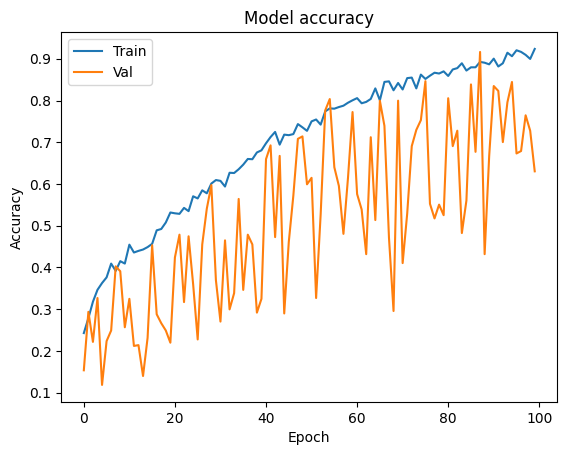

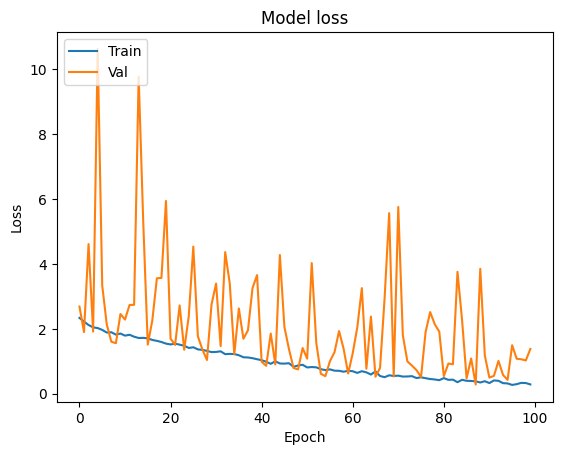

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


based on results above, the model learn well on training data but it is unstable at validation data.

let's load the best model we have to evaluate

In [20]:
model.load_weights('/kaggle/working/checkpoint.keras')

let's test the model on test data.

In [21]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes))

confusion_matrix = confusion_matrix(y_true, y_pred_classes)
print(confusion_matrix)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9218 - loss: 0.2375
Test accuracy: 0.9027237296104431
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step
              precision    recall  f1-score   support

           0       0.11      0.11      0.11       160
           1       0.13      0.14      0.13       149
           2       0.09      0.07      0.08       120
           3       0.19      0.18      0.19       180
           4       0.09      0.09      0.09       108
           5       0.19      0.19      0.19       180
           6       0.13      0.14      0.13       131

    accuracy                           0.14      1028
   macro avg       0.13      0.13      0.13      1028
weighted avg       0.14      0.14      0.14      1028

[[18 28 15 30 20 27 22]
 [31 21 11 26 13 26 21]
 [19 18  9 24 13 22 15]
 [30 27 20 33 22 28 20]
 [18 18  9 15 10 20 18]
 [29 25 27 22 16 34 27]
 [19 26 13 21 13 21 18]]


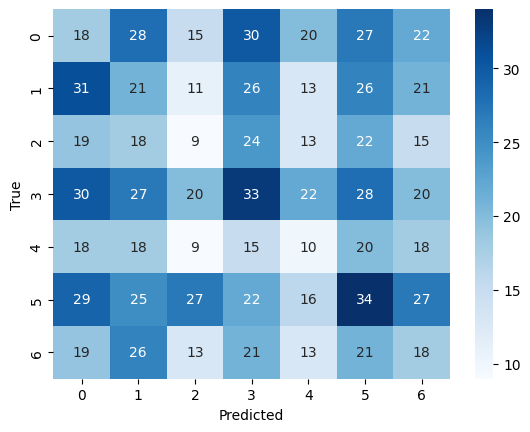

In [22]:
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()